# Predict Future Sales

------------------------------------------------------------------------------------------------------------------

You are provided with daily historical sales data. The task is to forecast the total amount of products sold in every shop for the test set. Note that the list of shops and products slightly changes every month. Creating a robust model that can handle such situations is part of the challenge.

# Imports

In [ ]:
# imports
import os

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

#import specific sklearn packages
from sklearn.model_selection import train_test_split


In [ ]:
# install kaggle to use Kaggle API
##!pip install -q kaggle

In [ ]:
# mkdir to create new directory in deepnote
# chmod 600 removes a warning label in a shared notebook environment
##!mkdir -p ~/.kaggle
##!cp kaggle.json ~/.kaggle/
##!ls ~/.kaggle
##!chmod 600 /root/.kaggle/kaggle.json
###!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
#kaggle competitions list

In [ ]:
##!kaggle datasets list

For whatever reason **Kaggle doesn't have the reference link for the datasets** listed under this competition. But as you can see from above, *some Kaggle users have translated* the mostly Russian fields so they're understandable. But they only did it for 3/6 of the files... 
- ~~remisharoon/predict-future-sales-translated-dataset~~  
- ywhenlyn/predict-future-sales-translated-to-english 

In [ ]:
##!kaggle competitions files competitive-data-science-predict-future-sales

In [ ]:
##!kaggle competitions download -w competitive-data-science-predict-future-sales -p /work/predict_future_sales/files##!kaggle competitions download -w competitive-data-science-predict-future-sales -p /work/predict_future_sales/files

In [ ]:
#item!kaggle datasets download ywhenlyn/predict-future-sales-translated-to-english -p /predict_future_sales/files

# Importing All Predict Sales Data

In [ ]:
#importing all the data frames
itemcats_df = pd.read_csv("/work/predict_future_sales/files/item_categories.csv") #Item Categories
items_df = pd.read_csv("/work/predict_future_sales/files/items.csv") # Items
salestrain_df = pd.read_csv("/work/predict_future_sales/files/sales_train.csv") #Sales Data - Training
shops_df = pd.read_csv("/work/predict_future_sales/files/shops.csv") # Shops

In [ ]:
# sample submisison dataframe
sample_df = pd.read_csv('/work/predict_future_sales/files/sample_submission.csv')

In [ ]:
# test data frame
test_df = pd.read_csv('/work/predict_future_sales/files/test.csv')

# File descriptions

itemcats_df  - supplemental information about the items categories.

items_df - supplemental information about the items/products.

salestrain_df - the training set. Daily historical data from January 2013 to October 2015.

shops_df - supplemental information about the shops.

----------------------------------------------------------------------------------------------------

test.csv - the test set. You need to forecast the sales for these shops and products for November 2015.

sample_submission.csv - a sample submission file in the correct format.







# Data EDA

In [ ]:
# creating a master list of all dataframes
df_list = [itemcats_df, items_df, salestrain_df, shops_df]

In [ ]:
# creating a loop to print head, description, info, and null sum for each datafram in master list 
for df in df_list:
    print(f'DATAFRAME HEAD: {df.head()}')
    print('-----------------------')
    print(f'DATAFRAME DESCRIPTION: {df.describe()}')
    print('-----------------------')
    print(f'DATAFAME INFO: {df.info()}')
    print('-----------------------')
    print(f'DATAFRAME NULL SUM: {df.isnull().sum()}')
    print('------------------------------------------------------------------------------')

DATAFRAME HEAD:            item_category_name  item_category_id
0  PC - Headsets / Headphones                 0
1           Accessories - PS2                 1
2           Accessories - PS3                 2
3           Accessories - PS4                 3
4           Accessories - PSP                 4
-----------------------
DATAFRAME DESCRIPTION:        item_category_id
count         84.000000
mean          41.500000
std           24.392622
min            0.000000
25%           20.750000
50%           41.500000
75%           62.250000
max           83.000000
-----------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   item_category_name  84 non-null     object
 1   item_category_id    84 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.4+ KB
DATAFAME INFO: None
-----------------------
DATAFRAME NULL SUM: i

In [ ]:
# checking itemcats_df column data types
itemcats_df.dtypes

item_category_name    object
item_category_id       int64
dtype: object

In [ ]:
# checking item_df column data types
items_df.dtypes

item_name           object
item_id              int64
item_category_id     int64
dtype: object

In [ ]:
# checking salestrain_df data types
salestrain_df.dtypes

date               object
date_block_num      int64
shop_id             int64
item_id             int64
item_price        float64
item_cnt_day      float64
dtype: object

In [ ]:
# changing salestrain 'item_cnt_day' col from float64 -> int16
salestrain_df['item_cnt_day'] = pd.to_numeric(salestrain_df['item_cnt_day'], downcast='signed')

In [ ]:
# changing salestrain 'date' col from object -> datetime
salestrain_df['date'] = pd.to_datetime(salestrain_df['date'])

In [ ]:
shops_df.dtypes

shop_name    object
shop_id       int64
dtype: object

# Combine DFs

In [ ]:
salestrain_df_combined=salestrain_df.merge(items_df,on='item_id')

In [ ]:
salestrain_df_combined.isnull().sum()

date                0
date_block_num      0
shop_id             0
item_id             0
item_price          0
item_cnt_day        0
item_name           0
item_category_id    0
dtype: int64

In [ ]:
salestrain_df_combined.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id
0,2013-02-01,0,59,22154,999.0,1,Scene 2012 (BD),37
1,2013-01-23,0,24,22154,999.0,1,Scene 2012 (BD),37
2,2013-01-20,0,27,22154,999.0,1,Scene 2012 (BD),37
3,2013-02-01,0,25,22154,999.0,1,Scene 2012 (BD),37
4,2013-03-01,0,25,22154,999.0,1,Scene 2012 (BD),37


In [ ]:
salestrain_df_combined=salestrain_df_combined.merge(itemcats_df,on='item_category_id')
salestrain_df_combined.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name
0,2013-02-01,0,59,22154,999.0,1,Scene 2012 (BD),37,Movie - Blu-Ray
1,2013-01-23,0,24,22154,999.0,1,Scene 2012 (BD),37,Movie - Blu-Ray
2,2013-01-20,0,27,22154,999.0,1,Scene 2012 (BD),37,Movie - Blu-Ray
3,2013-02-01,0,25,22154,999.0,1,Scene 2012 (BD),37,Movie - Blu-Ray
4,2013-03-01,0,25,22154,999.0,1,Scene 2012 (BD),37,Movie - Blu-Ray


In [ ]:
salestrain_df_combined=salestrain_df_combined.merge(shops_df,on='shop_id')
salestrain_df_combined.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name
0,2013-02-01,0,59,22154,999.0,1,Scene 2012 (BD),37,Movie - Blu-Ray,"Yaroslavl shopping center ""Altair"""
1,2013-04-26,3,59,944,150.0,1,2012 (BD),37,Movie - Blu-Ray,"Yaroslavl shopping center ""Altair"""
2,2013-06-26,5,59,944,199.5,1,2012 (BD),37,Movie - Blu-Ray,"Yaroslavl shopping center ""Altair"""
3,2013-07-20,6,59,944,199.5,1,2012 (BD),37,Movie - Blu-Ray,"Yaroslavl shopping center ""Altair"""
4,2013-09-14,8,59,944,299.0,2,2012 (BD),37,Movie - Blu-Ray,"Yaroslavl shopping center ""Altair"""


# Data Viz

In [ ]:
# adding features for separating date
salestrain_df_combined['year'] = salestrain_df_combined.date.dt.year
salestrain_df_combined['month'] = salestrain_df_combined.date.dt.month
salestrain_df_combined['day'] = salestrain_df_combined.date.dt.day

# adding revenue feature
salestrain_df_combined['revenue'] = salestrain_df_combined.item_price * salestrain_df_combined.item_cnt_day
salestrain_df_combined.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name,year,month,day,revenue
0,2013-02-01,0,59,22154,999.0,1,Scene 2012 (BD),37,Movie - Blu-Ray,"Yaroslavl shopping center ""Altair""",2013,2,1,999.0
1,2013-04-26,3,59,944,150.0,1,2012 (BD),37,Movie - Blu-Ray,"Yaroslavl shopping center ""Altair""",2013,4,26,150.0
2,2013-06-26,5,59,944,199.5,1,2012 (BD),37,Movie - Blu-Ray,"Yaroslavl shopping center ""Altair""",2013,6,26,199.5
3,2013-07-20,6,59,944,199.5,1,2012 (BD),37,Movie - Blu-Ray,"Yaroslavl shopping center ""Altair""",2013,7,20,199.5
4,2013-09-14,8,59,944,299.0,2,2012 (BD),37,Movie - Blu-Ray,"Yaroslavl shopping center ""Altair""",2013,9,14,598.0


<AxesSubplot:title={'center':'Sales by Month'}, xlabel='date_block_num'>

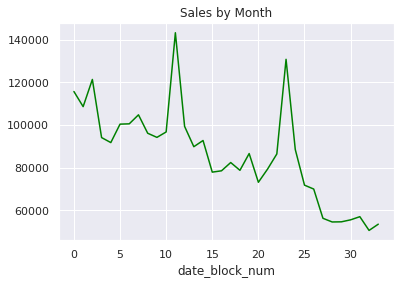

In [ ]:
sns.set()
salestrain_df_combined.groupby('date_block_num').date.count().plot.line(title='Sales by Month', color='green')

In [ ]:
# As we can see, sales are decreasing through the years. 
# We also see a spike sale during december. 
# Since, the dataset is up to October, are we seeing some spike in year 2015?

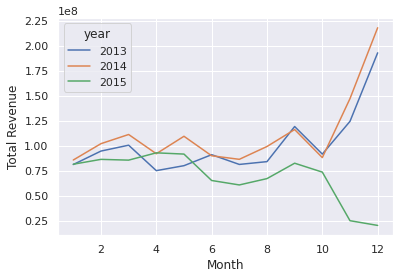

In [ ]:
# Plot total revenue by month for each year
salestrain_df_combined.groupby(['month', 'year']).sum()['revenue'].unstack().plot()
plt.xlabel('Month')
plt.ylabel('Total Revenue')
plt.show()

There are no sales spike on december 2015.

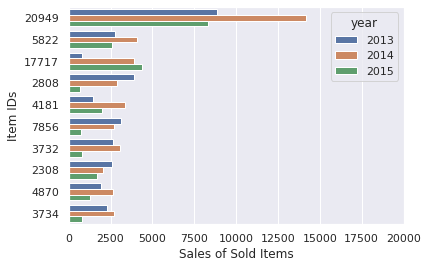

In [ ]:
# Plot the top 10 most items sold
sns.countplot(y='item_id', hue='year', data=salestrain_df_combined, order = salestrain_df_combined['item_id'].value_counts().iloc[:10].index)
plt.xlim(0,20000)
plt.xlabel('Sales of Sold Items')
plt.ylabel('Item IDs')
plt.show()

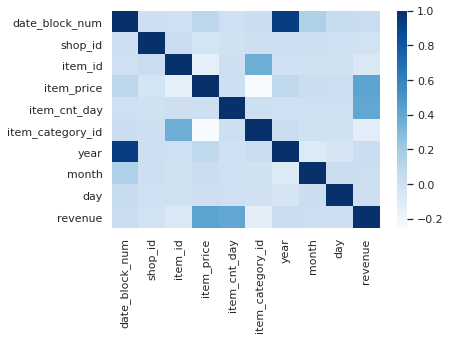

In [ ]:
sns.heatmap(salestrain_df_combined.corr(), cmap='Blues')
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=44fa2d56-e957-4313-be50-5c4ecc704dff' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>